In [ ]:
import os
import numpy as np
import pandas as pd
from  time import time
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import warnings
warnings.filterwarnings("ignore")

from params import *
from train_eval import *
import network
import utils_fn

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

# Define useful variables
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64

In [7]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

#### Load train/valid/test set and create Data Loader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device\n")

train_dataset = torch.load('data/train_dataset.pt')#, map_location=torch.device(device))
val_dataset = torch.load('data/val_dataset.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

x = next(iter(train_loader))[0]

print(f"Number of elements in train set: {len(train_dataset)}.")
print(f"Number of elements in valid set:  {len(val_dataset)}.")
print(f"Number of elements in test set:   {len(test_dataset)}.")
print(f"\nShape of each element in the dataloader: {x.shape}")

Using cuda device

Number of elements in train set: 1424.
Number of elements in valid set:  232.
Number of elements in test set:   232.

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])


The CIR has shape ($2$, $W$, $R$, $K$), where:

- $2$ is the number of convolutional channels (one for the real part of the CIR, one for the imaginary part);
- $W$ is the number of windows, in this case: $W=232$;
- $R$ is the number of range bins, in this case: $R=10$;
- $K$ is the length of each windows, in this case: $K=64$.

#### Plot some examples

In [5]:
ACTIVITIES = ["WALKING", "RUNNING", "SITTING", "HANDS"]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

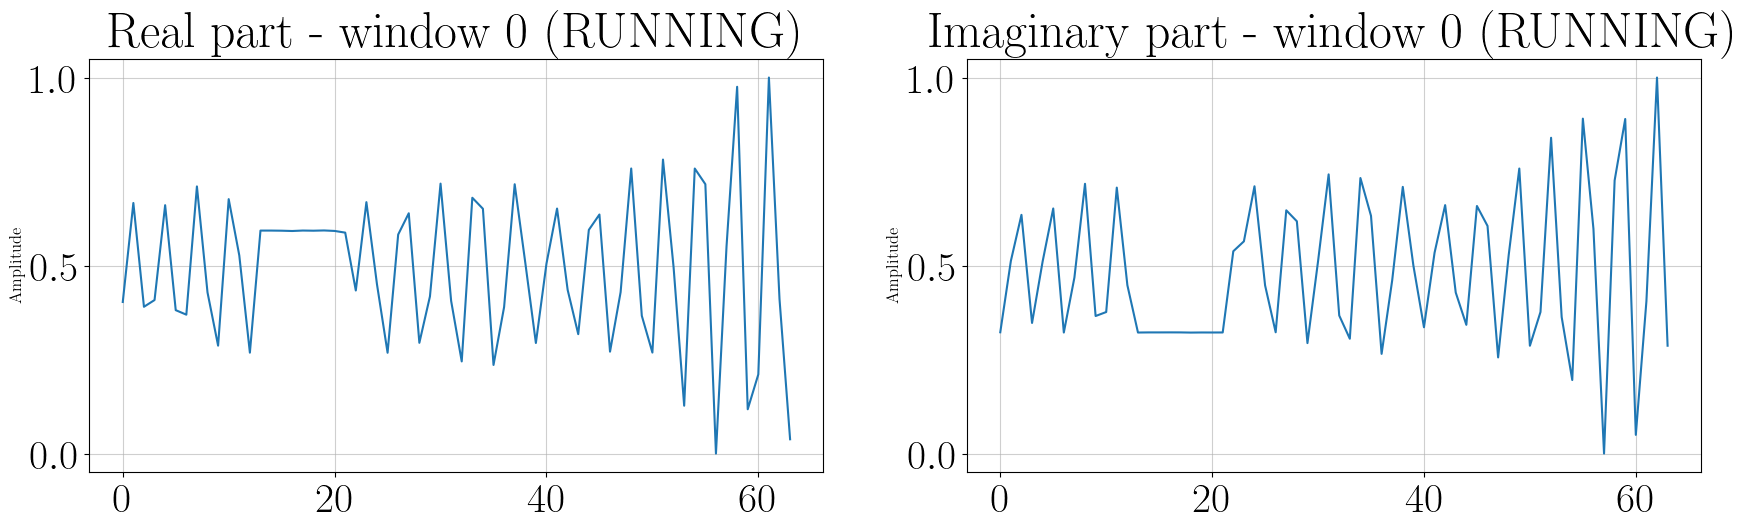

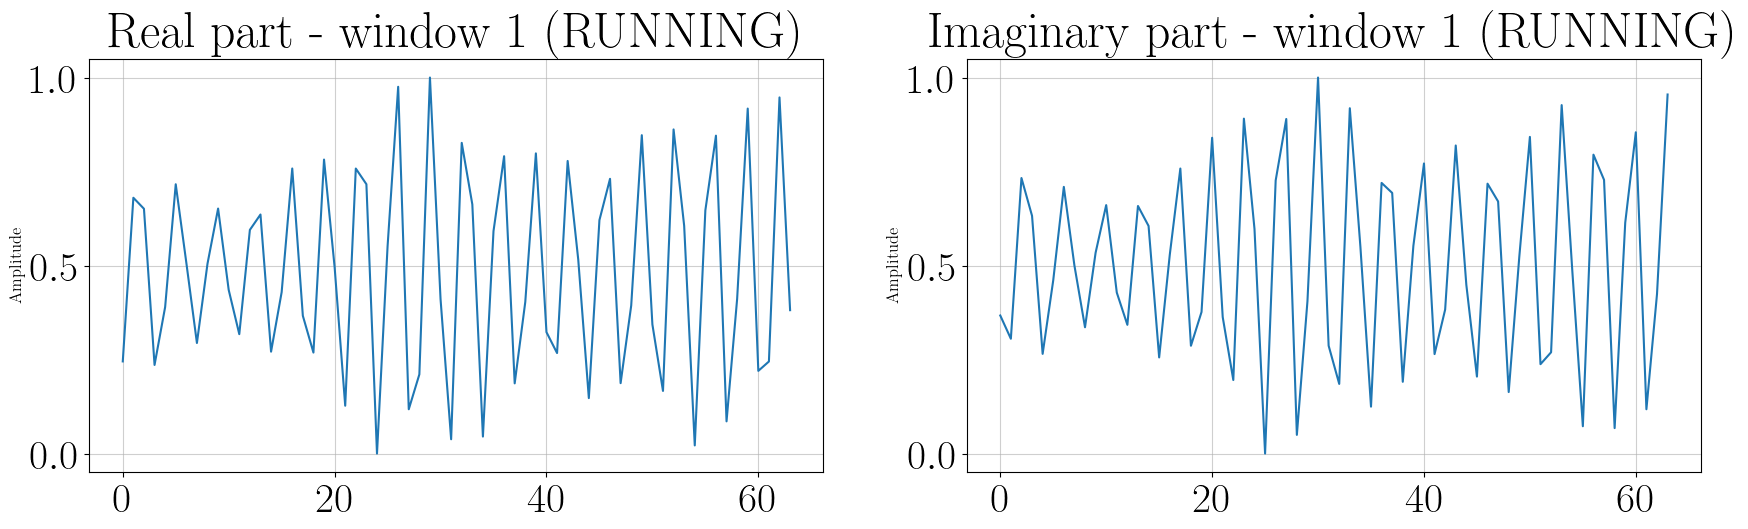

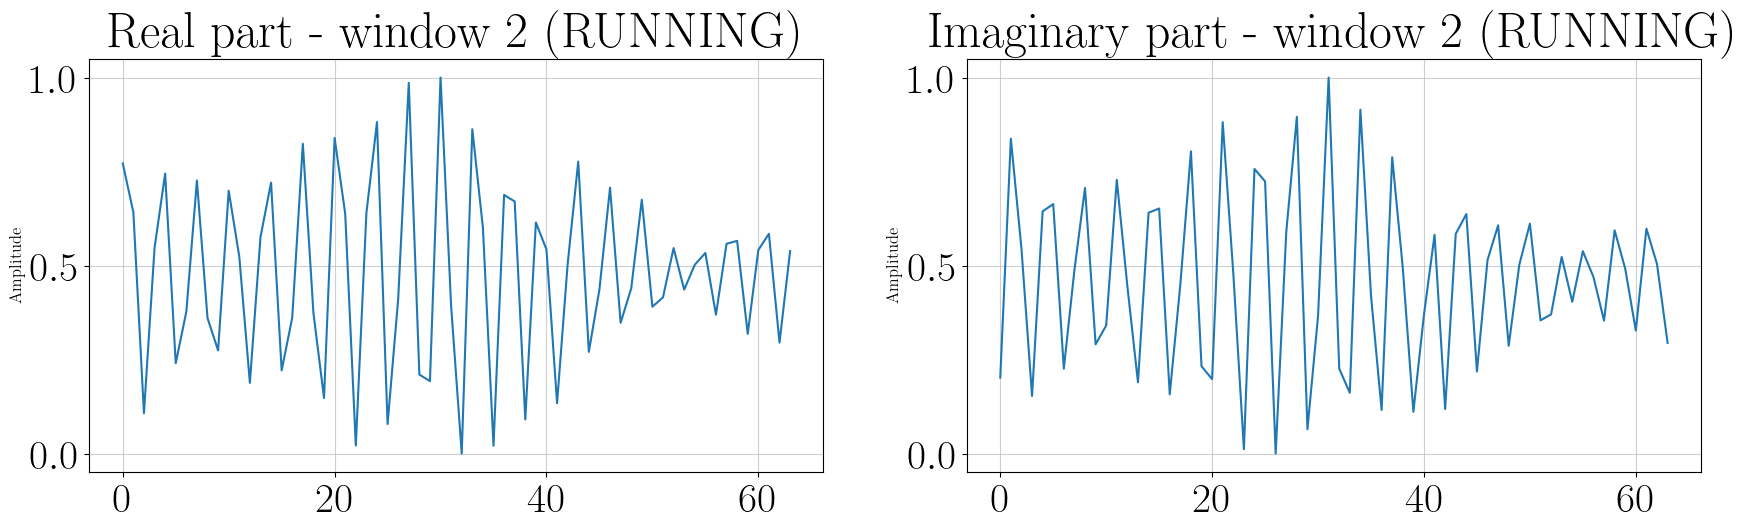

In [20]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

### Model definition

In [6]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        return encoded, decoded, clss

### Train with optimized hyperparams

In [4]:
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                    model = net, 
                                                    train = train_loader, 
                                                    valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = './model_opt_2.pt')


Epoch 1 - loss: 0.4153 | acc: 0.4708 | val_loss: 0.4535 | val_acc: 0.4659
Epoch 2 - loss: 0.2961 | acc: 0.705 | val_loss: 0.2951 | val_acc: 0.6136
Epoch 3 - loss: 0.2493 | acc: 0.7627 | val_loss: 0.2461 | val_acc: 0.6705
Epoch 4 - loss: 0.2509 | acc: 0.7401 | val_loss: 0.2682 | val_acc: 0.5909
Epoch 5 - loss: 0.2349 | acc: 0.7883 | val_loss: 0.2257 | val_acc: 0.7841
Epoch 6 - loss: 0.2283 | acc: 0.7817 | val_loss: 0.2525 | val_acc: 0.6818
Epoch 7 - loss: 0.2126 | acc: 0.8129 | val_loss: 0.2482 | val_acc: 0.6818
Epoch 8 - loss: 0.2029 | acc: 0.8364 | val_loss: 0.2091 | val_acc: 0.7614
Epoch 9 - loss: 0.2069 | acc: 0.8223 | val_loss: 0.2115 | val_acc: 0.7614
Epoch 10 - loss: 0.2024 | acc: 0.8437 | val_loss: 0.3063 | val_acc: 0.6818
Epoch 11 - loss: 0.2049 | acc: 0.8567 | val_loss: 0.229 | val_acc: 0.7955
Epoch 12 - loss: 0.1817 | acc: 0.8768 | val_loss: 0.2241 | val_acc: 0.7841
Epoch 13 - loss: 0.1797 | acc: 0.8919 | val_loss: 0.2572 | val_acc: 0.7386
Epoch 14 - loss: 0.1723 | acc: 0.898

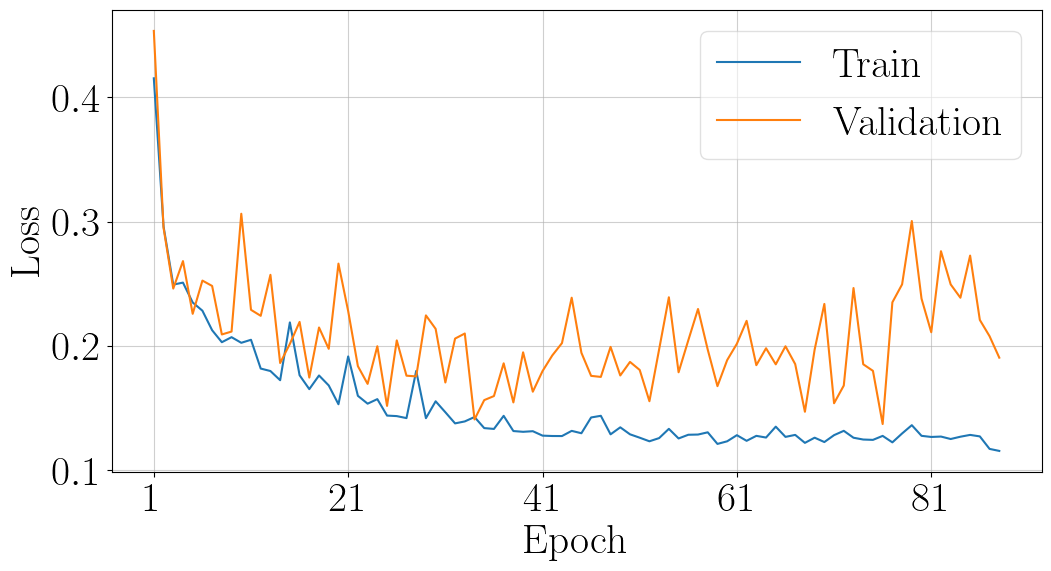

In [48]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_loss.png", bbox_inches='tight')
plt.show()

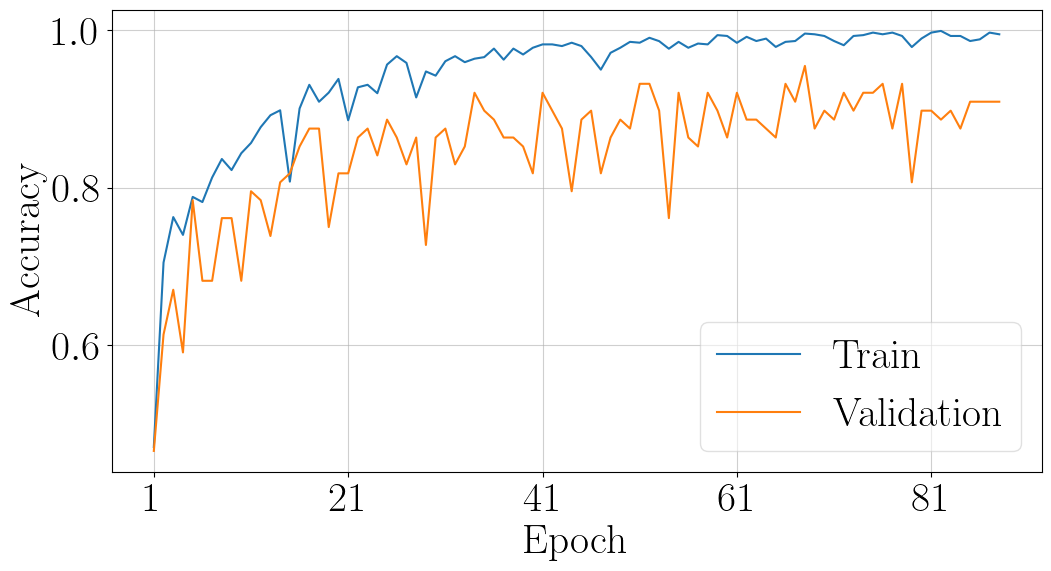

In [51]:
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_acc.png", bbox_inches='tight')
plt.show()

### Results on test set

In [7]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [42]:
acc, prec, rec, f1, conf_mx = evaluate(net, test_loader, out_dec="rate", 
                                    avg_type='macro', verbose=False)

AVERAGE TYPE: macro

Accuracy: 0.9698
Precision: 0.9653
Recall: 0.9533
F1 score: 0.9572


In [44]:
acc, prec, rec, f1, conf_mx = evaluate(net, test_loader, out_dec="rate", 
                                    avg_type='weighted', verbose=True)

AVERAGE TYPE: weighted

Accuracy: 0.9533
Precision: 0.9716
Recall: 0.9698
F1 score: 0.9696

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.98      0.98      0.98       125
     RUNNING       0.98      0.98      0.98        44
     SITTING       0.90      1.00      0.95        36
       HANDS       1.00      0.85      0.92        27

    accuracy                           0.97       232
   macro avg       0.97      0.95      0.96       232
weighted avg       0.97      0.97      0.97       232



### Plot the confusion matrix

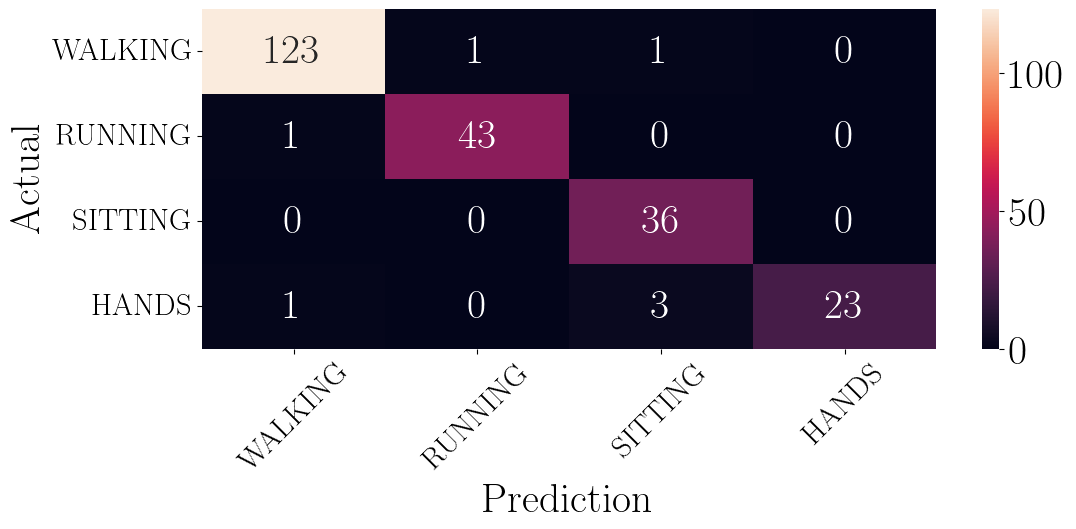

In [45]:
sns.heatmap(conf_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/confusion_mx_macro.pdf", bbox_inches='tight')
plt.show()

## Encoding CAE vs. LIF

In [8]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [ ]:
hidden_neurons_sae = [16, 32, 128]
train_loss_ls, val_loss_ls = [], []
train_acc_ls, val_acc_ls = [], []

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for hidd in hidden_neurons_sae:

    autoencoder = network.sae_lin2(
                            input_dim = 64, 
                            hidden_dim = hidd,
                            surr_grad = params_snn['surrogate_grad'],
                            learn_beta = params_snn['learn_beta'],
                            timesteps = N_WIN
                            ).to(device)
    
    net = LSE_1(autoencoder, classifier).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc = train_fn(
                                                    model = net, 
                                                    train = train_loader, 
                                                    valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = None)

    train_loss_ls.append(train_loss)
    val_loss_ls.append(val_loss)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(val_acc)

Epoch 1 - loss: 0.4281 | acc: 0.3817 | val_loss: 0.2742 | val_acc: 0.4886
Epoch 2 - loss: 0.2707 | acc: 0.3724 | val_loss: 0.2676 | val_acc: 0.5
Epoch 3 - loss: 0.2701 | acc: 0.3884 | val_loss: 0.2641 | val_acc: 0.5114
Epoch 4 - loss: 0.2701 | acc: 0.3919 | val_loss: 0.2703 | val_acc: 0.4659
Epoch 5 - loss: 0.2745 | acc: 0.3794 | val_loss: 0.2714 | val_acc: 0.4659
Epoch 6 - loss: 0.268 | acc: 0.3819 | val_loss: 0.2786 | val_acc: 0.3523
Epoch 7 - loss: 0.2641 | acc: 0.3767 | val_loss: 0.2593 | val_acc: 0.4432
Epoch 8 - loss: 0.252 | acc: 0.3858 | val_loss: 0.2538 | val_acc: 0.4318
Epoch 9 - loss: 0.2474 | acc: 0.4061 | val_loss: 0.2408 | val_acc: 0.5
Epoch 10 - loss: 0.2446 | acc: 0.4232 | val_loss: 0.2512 | val_acc: 0.4432
Epoch 11 - loss: 0.2386 | acc: 0.4524 | val_loss: 0.2375 | val_acc: 0.4091
Epoch 12 - loss: 0.2389 | acc: 0.4684 | val_loss: 0.2373 | val_acc: 0.4659
Epoch 13 - loss: 0.2225 | acc: 0.4973 | val_loss: 0.2059 | val_acc: 0.5568
Epoch 14 - loss: 0.2093 | acc: 0.5668 | va

[]

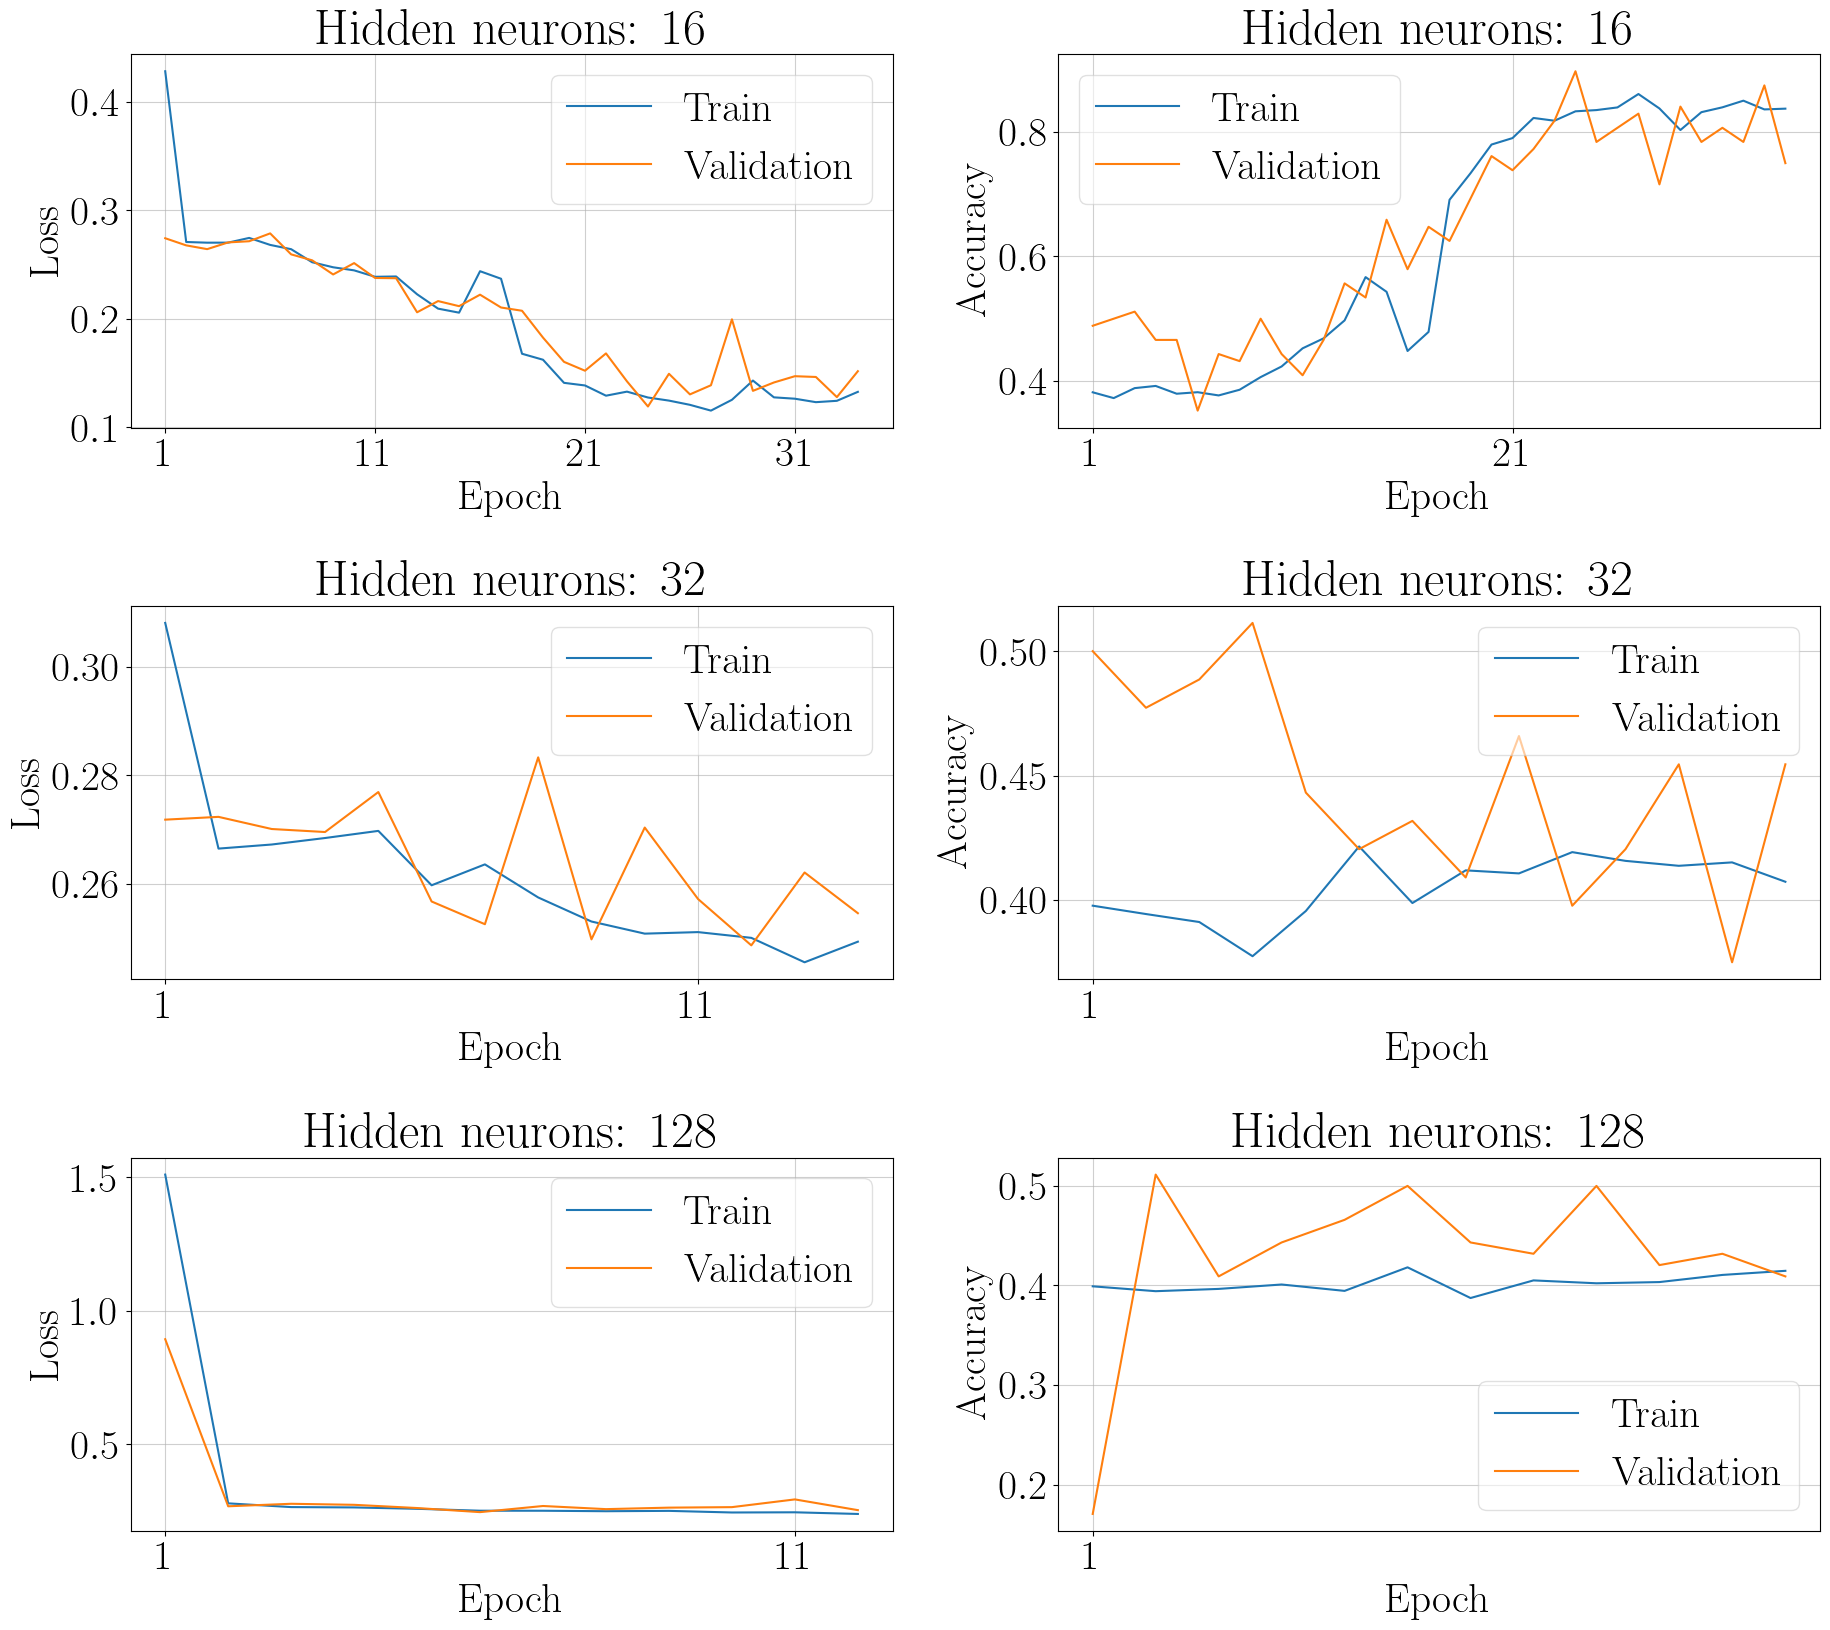

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(19,17))

for i in range(len(hidden_neurons_sae)):
    train_loss, val_loss = train_loss_ls[i], val_loss_ls[i]
    train_acc,  val_acc = train_acc_ls[i], val_acc_ls[i]

    axes[i,0].plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
    axes[i,0].plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
    axes[i,0].grid()
    axes[i,0].set_xlabel("Epoch")
    axes[i,0].set_ylabel("Loss")
    axes[i,0].set_xticks(np.arange(1, len(train_loss), 10))
    axes[i,0].set_title(f"Hidden neurons: {str(hidden_neurons_sae[i])}")
    axes[i,0].legend()

    axes[i,1].plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
    axes[i,1].plot(np.arange(1, len(val_acc)+1), val_acc, label='Validation')
    axes[i,1].grid()
    axes[i,1].set_xlabel("Epoch")
    axes[i,1].set_ylabel("Accuracy")
    axes[i,1].set_xticks(np.arange(1, len(train_acc), 20))
    axes[i,1].set_title(f"Hidden neurons: {str(hidden_neurons_sae[i])}")
    axes[i,1].legend()

plt.tight_layout()
plt.plot()


In [ ]:
autoencoder = network.sae_lin2(
                            input_dim = 64, 
                            hidden_dim = 16,
                            surr_grad = params_snn['surrogate_grad'],
                            learn_beta = params_snn['learn_beta'],
                            timesteps = N_WIN
                            ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE_1(autoencoder, classifier).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc = train_fn(
                                                model = net, 
                                                train = train_loader, 
                                                valid = val_loader,
                                                loss_fn_cae = params_cae['loss_fn'], 
                                                out_dec = params_snn['output_dec'],
                                                optimizer = optimizer, 
                                                acc_steps = params_train['acc_steps'],
                                                alpha = params_train['alpha'], 
                                                beta = params_train['beta'], 
                                                Lambda = params_train['lambda_reg'], 
                                                epochs = params_train['epochs'], 
                                                patience = params_train['patience'], 
                                                path = 'models/model_sae2.pt')

Epoch 1 - loss: 0.2682 | acc: 0.3977 | val_loss: 0.2717 | val_acc: 0.5114
Epoch 2 - loss: 0.2676 | acc: 0.3977 | val_loss: 0.2697 | val_acc: 0.5114
Epoch 3 - loss: 0.2664 | acc: 0.3979 | val_loss: 0.2697 | val_acc: 0.5114
Epoch 4 - loss: 0.264 | acc: 0.3977 | val_loss: 0.2448 | val_acc: 0.5114
Epoch 5 - loss: 0.2645 | acc: 0.398 | val_loss: 0.2696 | val_acc: 0.5114
Epoch 6 - loss: 0.2568 | acc: 0.3976 | val_loss: 0.2403 | val_acc: 0.5114
Epoch 7 - loss: 0.2416 | acc: 0.4266 | val_loss: 0.2267 | val_acc: 0.5227
Epoch 8 - loss: 0.2326 | acc: 0.5005 | val_loss: 0.2475 | val_acc: 0.4545
Epoch 9 - loss: 0.1804 | acc: 0.6024 | val_loss: 0.1924 | val_acc: 0.5682
Epoch 10 - loss: 0.185 | acc: 0.5975 | val_loss: 0.1746 | val_acc: 0.5455
Epoch 11 - loss: 0.1629 | acc: 0.6339 | val_loss: 0.1643 | val_acc: 0.6023
Epoch 12 - loss: 0.1513 | acc: 0.6705 | val_loss: 0.1697 | val_acc: 0.6364
Epoch 13 - loss: 0.15 | acc: 0.6803 | val_loss: 0.1773 | val_acc: 0.5909
Epoch 14 - loss: 0.1492 | acc: 0.6906 |

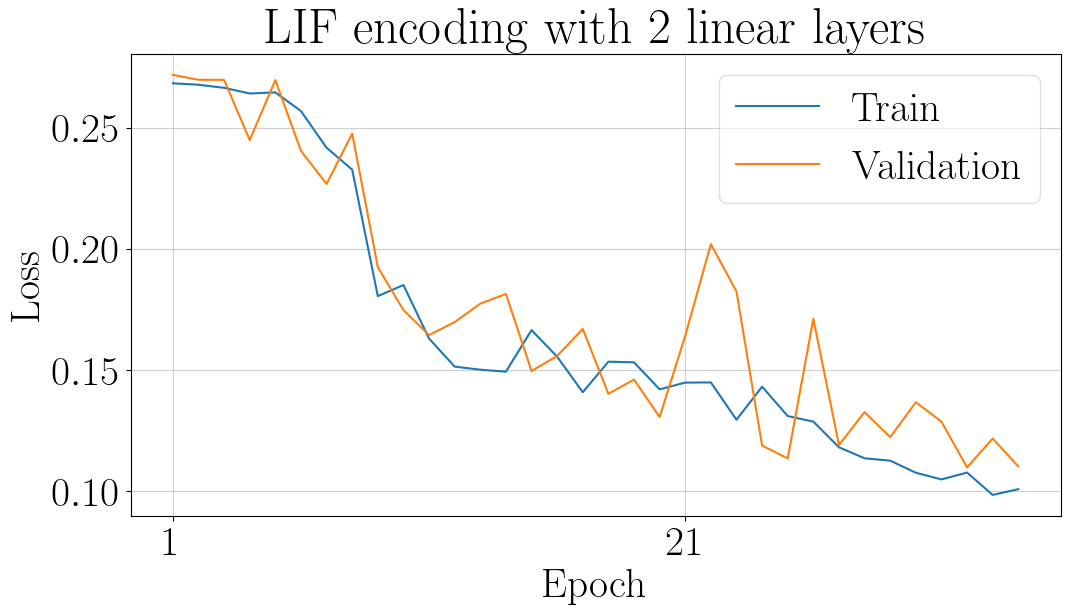

In [26]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LIF encoding with 2 linear layers")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/LIF_enc/train_val_loss_1.png", bbox_inches='tight')
plt.show()

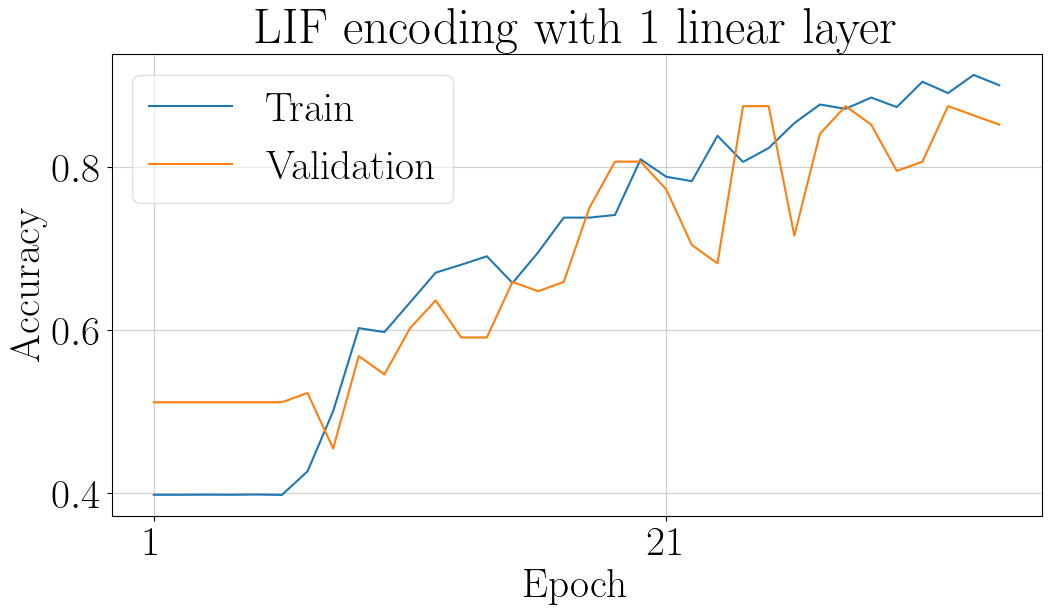

In [27]:
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LIF encoding with 1 linear layer")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/LIF_enc/train_val_acc.png", bbox_inches='tight')
plt.show()

In [ ]:
path = "./models/model_sae2.pt"
autoencoder = network.sae_lin2(
                        input_dim = 64, 
                        hidden_dim = 16,
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE_1(autoencoder, classifier).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE_1(
  (autoencoder): sae_lin2(
    (enc1): Linear(in_features=64, out_features=16, bias=True)
    (lif_enc1): Leaky()
    (enc2): Linear(in_features=16, out_features=64, bias=True)
    (lif_code): Leaky()
    (dec1): Linear(in_features=64, out_features=16, bias=True)
    (lif_dec1): Leaky()
    (dec2): Linear(in_features=16, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [49]:
acc, prec, rec, f1, conf_mx = evaluate(net, test_loader, 
                                        out_dec="rate", 
                                        avg_type='macro',
                                        verbose=False)

acc_w, prec_w, rec_w, f1_w, conf_mx_w = evaluate(net, test_loader, 
                                            out_dec="rate", 
                                            avg_type='weighted')

AVERAGE TYPE: macro

Accuracy: 0.8534
Precision: 0.8615
Recall: 0.7848
F1 score: 0.7975
AVERAGE TYPE: weighted

Accuracy: 0.7848
Precision: 0.8678
Recall: 0.8534
F1 score: 0.8472

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.89      0.94      0.92       125
     RUNNING       0.84      0.70      0.77        44
     SITTING       0.71      0.97      0.82        36
       HANDS       1.00      0.52      0.68        27

    accuracy                           0.85       232
   macro avg       0.86      0.78      0.80       232
weighted avg       0.87      0.85      0.85       232



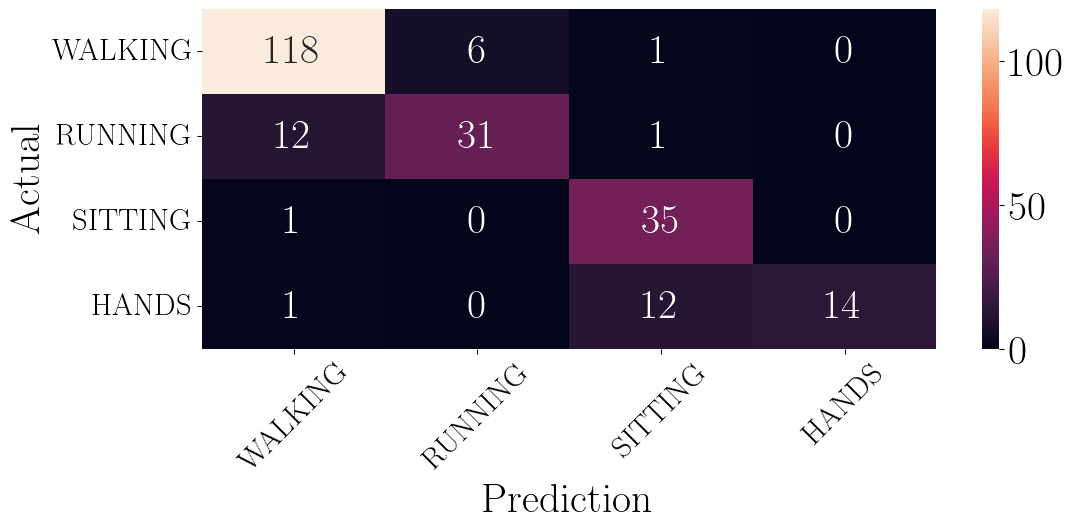

In [50]:
sns.heatmap(conf_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/confusion_mx_macro_sae_lin.png", bbox_inches='tight')
plt.show()

## Encoding capacity

In [ ]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [10]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [ ]:
path = "./models/model_sae1.pt"
autoencoder = network.sae_lin(
                        input_dim = 64, 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net_1 = LSE_1(autoencoder, classifier).to(device)
net_1.load_state_dict(torch.load(path))
net_1.eval()

LSE_1(
  (autoencoder): sae_lin(
    (encoder): Linear(in_features=64, out_features=64, bias=True)
    (lif_code): Leaky()
    (decoder): Linear(in_features=64, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [54]:
loss_fn = torch.nn.MSELoss()

loss_cae, loss_sae = 0, 0
sparsity_cae, sparsity_sae = [], [] 
shape_prod = 2*232*64*10

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            encoded, decoded, spk_out = net(X.float())
            encoded1, decoded1, spk_out1 = net_1(X.float())

            loss_cae += loss_fn(decoded, X.float())
            loss_sae += loss_fn(decoded1, X.float())

            sparsity_cae.append((1-torch.sum(abs(encoded))/shape_prod).item())

            sparsity_sae.append((1-torch.sum(abs(encoded1))/shape_prod).item())
            
        loss_cae = loss_cae / len(test_loader)
        loss_sae = loss_sae / len(test_loader)

print(f"Reconstruction error of CAE: {round(loss_cae.item(), 4)}")
print(f"Reconstruction error of SAE: {round(loss_sae.item(), 4)}\n")
print(f"Average sparsity of CAE encoding: {round(np.mean(sparsity_cae), 4)}")
print(f"Average sparsity of SAE encoding: {round(np.mean(sparsity_sae), 4)}")

Reconstruction error of CAE: 0.0194
Reconstruction error of SAE: 0.0571

Average sparsity of CAE encoding: 0.7261
Average sparsity of SAE encoding: 0.9678


### Number of trainable parameters and weight of the model

In [ ]:
print(f"# of trainable parameters of CAE: {utils_fn.count_params(net)}")
print(f"# of trainable parameters of SAE: {utils_fn.count_params(net_1)}\n")
print(f"Model size in MB of CAE: {utils_fn.model_size_in_mb(net)} MB")
print(f"Model size in MB of SAE: {utils_fn.model_size_in_mb(net_1)} MB")

# of trainable parameters of CAE: 343380
# of trainable parameters of SAE: 181256

Model size in MB of CAE: 1.31 MB
Model size in MB of SAE: 0.69 MB


## Aircraft marshaling

Compare the encoding with the procedure in this paper

In [118]:
x = train_dataset[0]
x[0].shape

torch.Size([2, 232, 10, 64])

In [6]:
def binary_encoding(X):
    """
    X: list of batch tuples
    Returns: tensor of shape (2, 232, 10, 64) with values {-1, 0, 1}
    """
    cir = torch.stack([el[0] for el in X], dim=0) # cir signals
    muD = torch.stack([el[1] for el in X], dim=0)
    Y = torch.stack([el[-1] for el in X], dim=0) # label

    # compute first-order difference along dim=3 (64)
    s_diff = cir[:, :, :, :, 1:] - cir[:, :, :, :, :-1]  # shape (8, 2, 232, 10, 63)

    # repeat the first column to pad and match original shape
    first_col = s_diff[:, :, :, :, 0:1]  # shape (8, 2, 10, 1, 232)
    s = torch.cat([first_col, s_diff], dim=-1)  # shape (8, 2, 232, 10, 64)

    # compute std over dim=3 (64), then mean over dim=2 (10)
    std_over_time = s.std(dim=-1, keepdim=True)  # shape (8, 2, 232, 10, 1)
    alpha = std_over_time.mean(dim=-2, keepdim=True)  # shape (8, 2, 232, 1, 1)

    # thresholding
    output = torch.zeros_like(s)
    output[s > alpha] = 1
    output[s < -alpha] = -1
    
    return (output, muD, Y)

train_loader_enc = DataLoader(
                            train_dataset,
                            batch_size=batch,
                            shuffle=True,
                            num_workers=2,
                            collate_fn=binary_encoding,
                            )

val_loader_enc = DataLoader(
                            val_dataset,
                            batch_size=batch,
                            collate_fn=binary_encoding,
                            )

test_loader_enc = DataLoader(
                            test_dataset,
                            batch_size=1,
                            collate_fn=binary_encoding,
                            )

### Sparsity of the encoding

In [15]:
sparsity = 0
with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            encoded, decoded, spk_out = net(X.float())

            sparsity += 1- abs(encoded).sum().item() / encoded.numel()

avg_sparsity = round(sparsity / len(test_loader), 5)
print(f"Sparsity with LSE: {avg_sparsity}")
            

Sparsity with LSE: 0.72607


In [160]:
sparsity1 = 0
with torch.no_grad():
        for X in test_loader_enc:
            X = X[0]
            sparsity1 += 1- abs(X).sum().item() / X.numel()

avg_sparsity1 = round(sparsity1 / len(test_loader_enc), 5)
print(f"Sparsity with binary thresholding: {avg_sparsity1}")

Sparsity with binary thresholding: 0.71265


### Train the snn_1 network with these encoded data to do HAR

In [165]:
classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
optimizer = torch.optim.Adam(classifier.parameters(), 
                             lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc = train_snn(
                                                  model = classifier, 
                                                  train = train_loader_enc, 
                                                  valid = val_loader_enc,
                                                  optimizer = optimizer,
                                                  epochs = 100, 
                                                  patience = 10, 
                                                  path = 'models/model_snn_clss_delta_thr.pt'
                                                  )

Epoch 1 - loss: 0.9873 | acc: 0.5829 | val_loss: 0.6461 | val_acc: 0.681
Epoch 2 - loss: 0.4331 | acc: 0.783 | val_loss: 0.5962 | val_acc: 0.6897
Epoch 3 - loss: 0.3202 | acc: 0.8476 | val_loss: 0.4363 | val_acc: 0.806
Epoch 4 - loss: 0.2184 | acc: 0.9003 | val_loss: 0.351 | val_acc: 0.8793
Epoch 5 - loss: 0.1108 | acc: 0.9663 | val_loss: 0.2297 | val_acc: 0.9138
Epoch 6 - loss: 0.0422 | acc: 0.9838 | val_loss: 0.2938 | val_acc: 0.9353
Epoch 7 - loss: 0.0286 | acc: 0.9902 | val_loss: 0.2371 | val_acc: 0.9397
Epoch 8 - loss: 0.0116 | acc: 0.9958 | val_loss: 0.276 | val_acc: 0.931
Epoch 9 - loss: 0.0033 | acc: 0.9993 | val_loss: 0.2504 | val_acc: 0.9353
Epoch 10 - loss: 0.001 | acc: 1.0 | val_loss: 0.2695 | val_acc: 0.9397
Epoch 11 - loss: 0.0004 | acc: 1.0 | val_loss: 0.2727 | val_acc: 0.9612
Epoch 12 - loss: 0.0005 | acc: 1.0 | val_loss: 0.2644 | val_acc: 0.944
Epoch 13 - loss: 0.0009 | acc: 1.0 | val_loss: 0.3137 | val_acc: 0.9397
Epoch 14 - loss: 0.0003 | acc: 1.0 | val_loss: 0.3194 

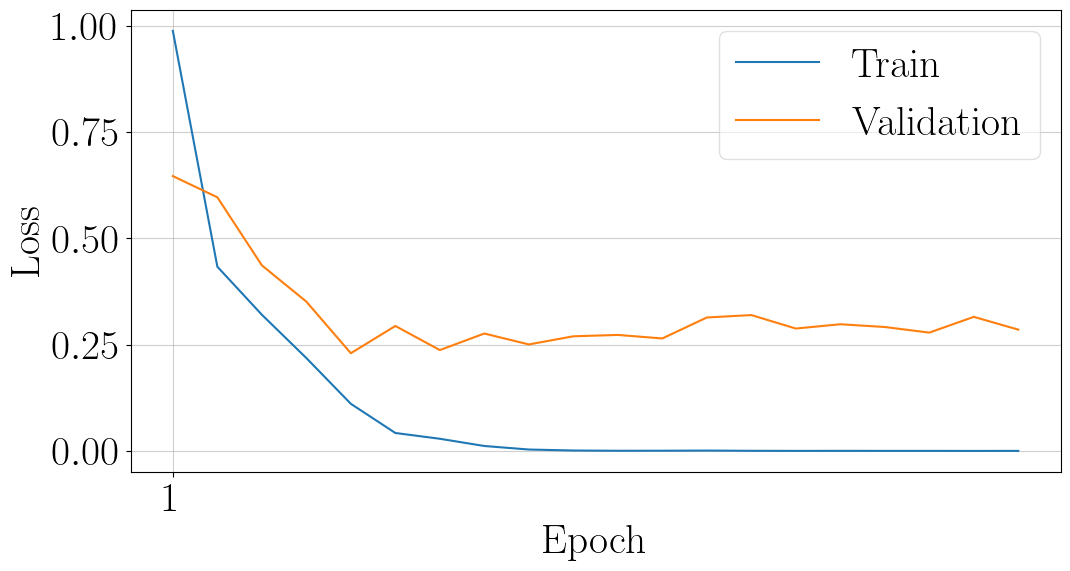

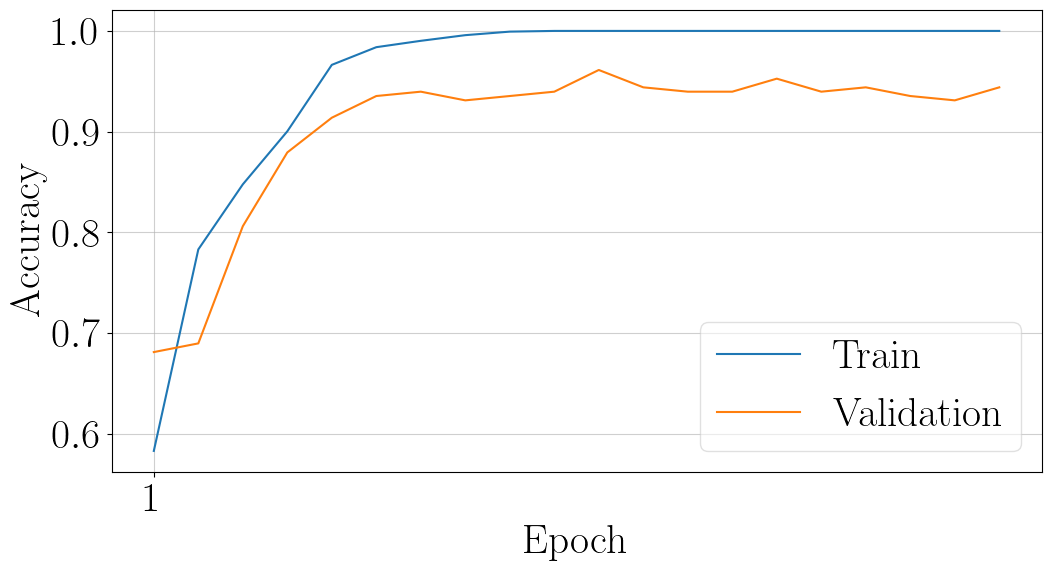

In [ ]:
utils_fn.plot_curves(train_loss, val_loss, train_acc, val_acc,
                  save_fig=False, name=None)

In [ ]:
classifier.eval()
acc, prec, rec, f1, conf_mx = evaluate_1(classifier, test_loader_enc, 
                                        out_dec="rate", 
                                        avg_type='macro',
                                        verbose=False)

acc_w, prec_w, rec_w, f1_w, conf_mx_w = evaluate_1(classifier, test_loader_enc, 
                                            out_dec="rate", 
                                            avg_type='weighted')

AVERAGE TYPE: macro

Accuracy: 0.9569
Precision: 0.9585
Recall: 0.9373
F1 score: 0.9474
AVERAGE TYPE: weighted

Accuracy: 0.9373
Precision: 0.9571
Recall: 0.9569
F1 score: 0.9566

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.95      0.98      0.97       125
     RUNNING       0.98      0.93      0.95        44
     SITTING       0.94      0.94      0.94        36
       HANDS       0.96      0.89      0.92        27

    accuracy                           0.96       232
   macro avg       0.96      0.94      0.95       232
weighted avg       0.96      0.96      0.96       232



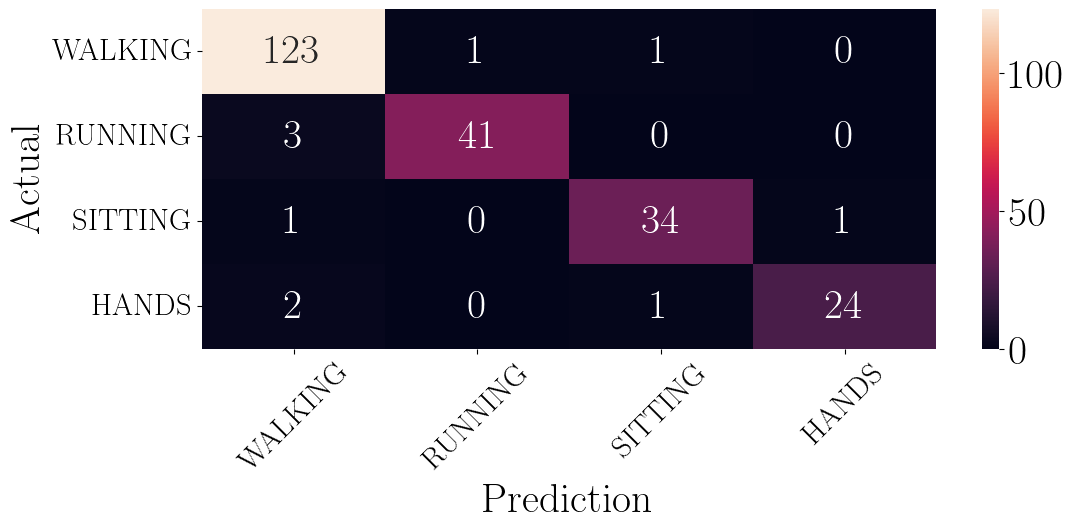

In [170]:
sns.heatmap(conf_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/confusion_mx_macro_sae_lin.png", bbox_inches='tight')
plt.show()

### Average number of spikes per neuron

In [4]:
class snn_1(nn.Module):

    def __init__(self, input_dim, hidden, timesteps, n_classes, surr_grad, learn_thr, learn_beta):
        super(snn_1, self).__init__()

        self.input_dim = input_dim        
        self.hidden = hidden
        self.timesteps = timesteps
        self.n_classes = n_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # layer input
        self.fc_in = nn.Linear(in_features=input_dim, out_features=self.hidden[0])
        self.lif_in = snn.Leaky(beta=torch.rand(self.hidden[0]), 
                                threshold=torch.rand(self.hidden[0]),
                                learn_beta=self.learn_beta, learn_threshold=self.learn_thr, 
                                spike_grad=self.surr_grad)

        # layer hidden
        self.fc_hidden = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden = snn.Leaky(beta=torch.rand(self.hidden[1]), 
                                    threshold=torch.rand(self.hidden[1]),
                                    learn_beta=self.learn_beta, learn_threshold=self.learn_thr, 
                                    spike_grad=self.surr_grad)
        
        # layer output
        self.fc_out = nn.Linear(in_features=self.hidden[1], out_features=n_classes)
        self.li_out = snn.Leaky(beta=torch.rand(n_classes), threshold=1.0,
                                #learn_threshold=self.learn_thr, 
                                learn_beta=self.learn_beta,
                                spike_grad=self.surr_grad)

    def forward(self, x):

        mem_in = self.lif_in.init_leaky()
        mem_hid = self.lif_hidden.init_leaky()
        mem_out = self.li_out.init_leaky()
        
        # Record the final layer
        spk_rec = []
        mem_rec = []

        spike_count1 = torch.zeros(self.hidden[0], self.timesteps)
        spike_count2 = torch.zeros(self.hidden[1], self.timesteps)
        spike_count3 = torch.zeros(self.n_classes, self.timesteps)

        for step in range(self.timesteps): # n. timesteps = n. windows

            x_tmstp = torch.reshape(x[:, :, step, :, :], (x.shape[0], -1)) # ~ [batch, 2*10*64]

            cur_in = self.fc_in(x_tmstp) # ~ [batch, 16]
            spk_in, mem_in = self.lif_in(cur_in, mem_in)
            spike_count1[:, step] = spk_in

            cur_hid = self.fc_hidden(spk_in) # ~ [batch, 1]
            spk_hid, mem_hid = self.lif_hidden(cur_hid, mem_hid)
            spike_count2[:, step] = spk_hid

            cur_out = self.fc_out(spk_hid) # ~ [batch, num_classes]
            spk_out, mem_out = self.li_out(cur_out, mem_out)
            spike_count3[:, step] = spk_out

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), spike_count1, spike_count2, spike_count3 #, torch.stack(mem_rec, dim=0)

In [5]:
classifier =  snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

path = 'models/model_snn_clss_delta_thr.pt'
classifier.load_state_dict(torch.load(path))
classifier.eval()

snn_1(
  (fc_in): Linear(in_features=1280, out_features=128, bias=True)
  (lif_in): Leaky()
  (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
  (lif_hidden): Leaky()
  (fc_out): Linear(in_features=64, out_features=4, bias=True)
  (li_out): Leaky()
)

In [28]:
tot_spike_count = 0

with torch.no_grad():
        for X, _, y in test_loader_enc:
            X = X.to(device)
        
            spk_out, spike_count1,  spike_count2, spike_count3 = classifier(X.float())

            tot_spike_count += (spike_count1.sum()+spike_count2.sum()+spike_count3.sum())/((128+64+4)*232)

tot_spike_count.item() / len(test_loader_enc)


0.14836201174505825

In [ ]:
spike_count1.mean()

tensor(0.1311)

In [10]:
spike_count2.mean()

tensor(0.1331)

In [3]:
spike_count3.mean()

NameError: name 'spike_count3' is not defined

In [2]:
spike_count1.shape

NameError: name 'spike_count1' is not defined

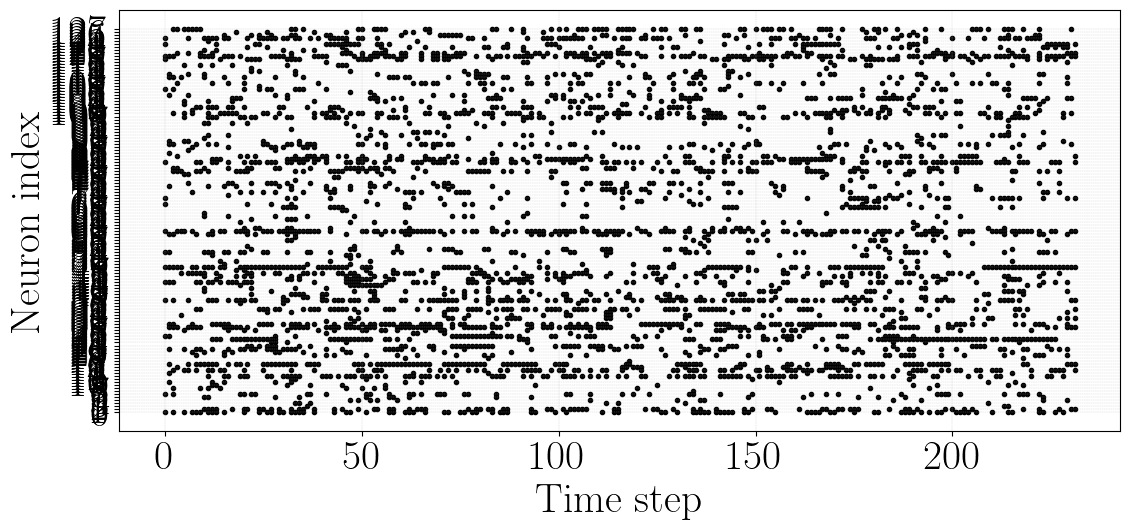

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count1, 0, 1)) # layer input

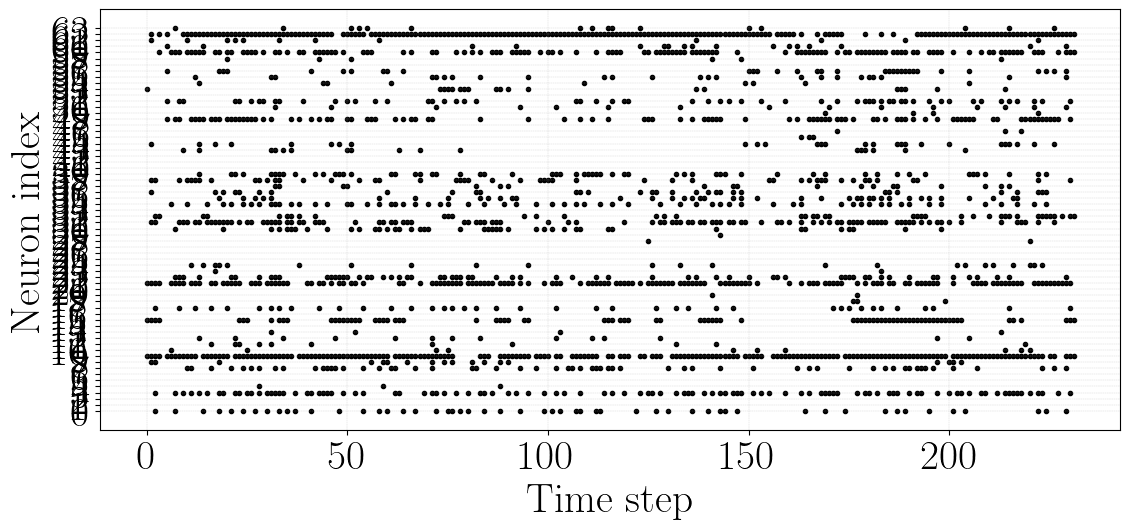

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count2, 0, 1)) # hidden layer

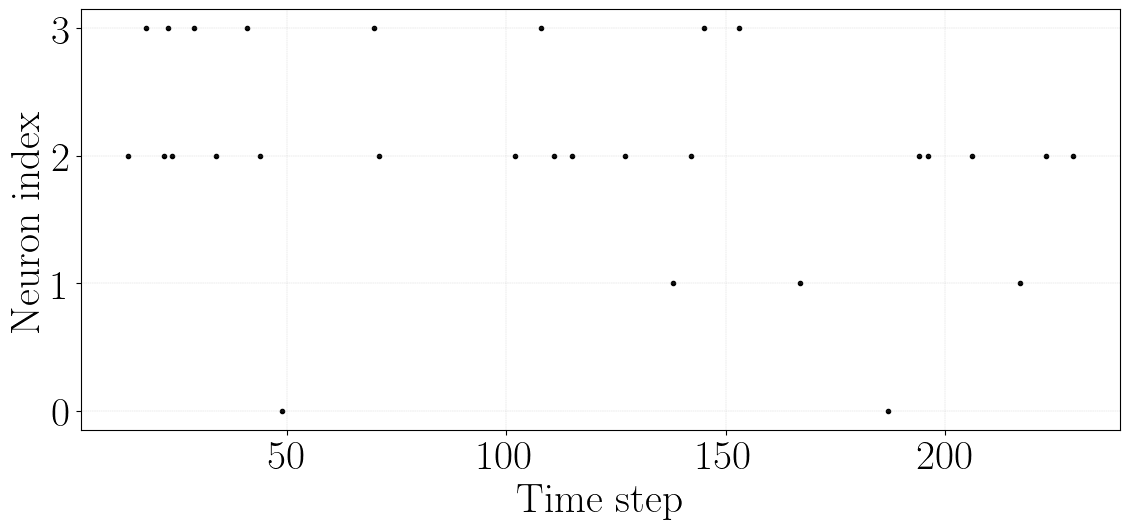

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count3, 0, 1)) # output layer

### nostro approccio

In [20]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss, x1, x2, x3 = self.snn(encoded)  
        return encoded, decoded, clss, x1, x2, x3

In [16]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [26]:
tot_spike_count = 0

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)
        
            encoded, dec, clss, spike_count1, spike_count2, spike_count3 = net(X.float())

            tot_spike_count += (spike_count1.sum()+spike_count2.sum()+spike_count3.sum())/((128+64+4)*232)

tot_spike_count.item() / len(test_loader)


0.16434373526737608

In [27]:
print(spike_count1.mean())
print(spike_count2.mean())
print(spike_count3.mean())

tensor(0.1617)
tensor(0.2218)
tensor(0.0302)


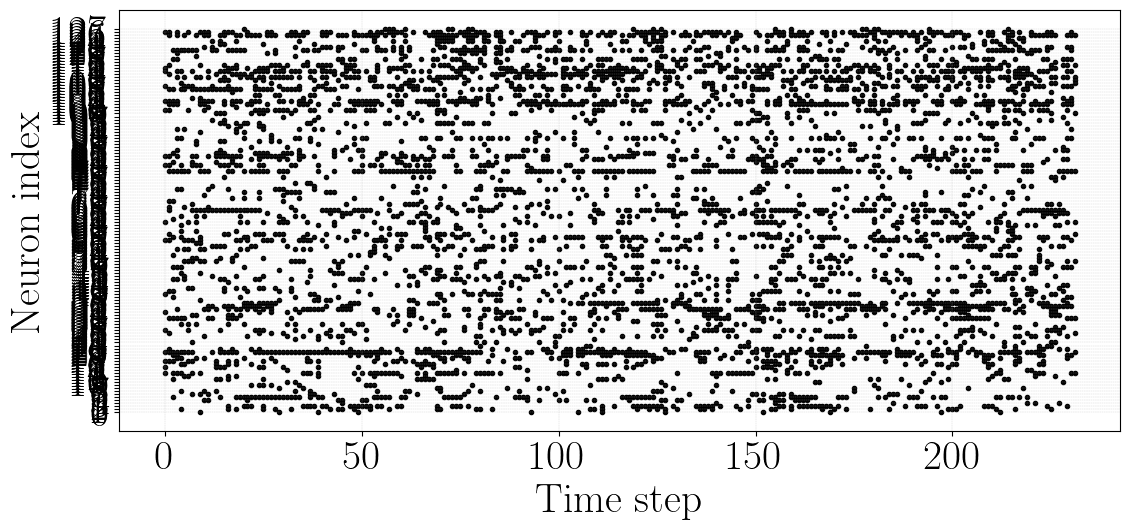

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count1, 0, 1)) # input layer

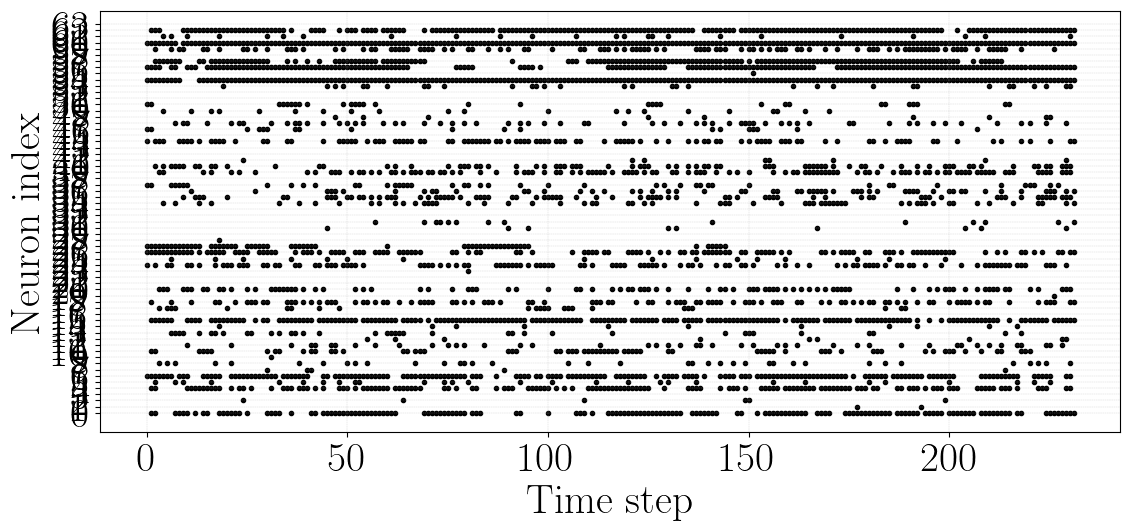

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count2, 0, 1)) # hidden layer

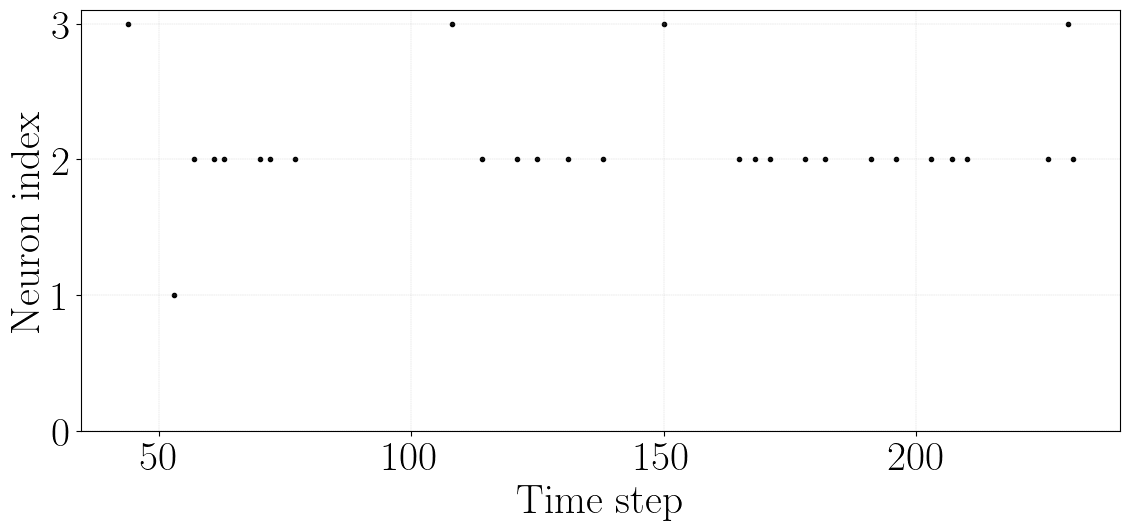

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count3, 0, 1)) # output layer